In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def dx_dt(t, x, y, z, sigma, b, r):
    return sigma * (y - x)

def dy_dt(t, x, y, z, sigma, b, r):
    # на фотке "x * (r - z) + y"
    return x * (r - z) - y

def dz_dt(t, x, y, z, sigma, b, r):
    # на фотке "- x * y - b * z"
    return x * y - b * z

In [4]:
sigma = 10
b = 8 / 3
rs = [0.5, 10, 24.06, 30]
dt = 0.0001
max_t = 20

In [5]:
def euler(r, t0=0, x0=13.41265629, y0=13.46430003, z0=33.46156416):
    t = t0
    x = x0
    y = y0
    z = z0
    
    ts = [t0]
    xs = [x0]
    ys = [y0]
    zs = [z0]
    
    while t < max_t:
        x_i = dx_dt(t, x, y, z, sigma, b, r) * dt
        y_i = dy_dt(t, x, y, z, sigma, b, r) * dt
        z_i = dz_dt(t, x, y, z, sigma, b, r) * dt
        
        t += dt
        x += x_i
        y += y_i
        z += z_i
        
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    
    return ts, xs, ys, zs

In [6]:
def RK4(r, t0=0, x0=13.41265629, y0=13.46430003, z0=33.46156416):
    t = t0
    x = x0
    y = y0
    z = z0
    
    ts = [t0]
    xs = [x0]
    ys = [y0]
    zs = [z0]
    
    while t < max_t:       
        k1 = dx_dt(t           , x                , y, z, sigma, b, r)
        k2 = dx_dt(t + 0.5 * dt, x + 0.5 * dt * k1, y, z, sigma, b, r)
        k3 = dx_dt(t + 0.5 * dt, x + 0.5 * dt * k2, y, z, sigma, b, r)
        k4 = dx_dt(t + dt      , x + dt * k3      , y, z, sigma, b, r)
        x_i = dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6 
        
        k1 = dy_dt(t           , x, y                , z, sigma, b, r)
        k2 = dy_dt(t + 0.5 * dt, x, y + 0.5 * dt * k1, z, sigma, b, r)
        k3 = dy_dt(t + 0.5 * dt, x, y + 0.5 * dt * k2, z, sigma, b, r)
        k4 = dy_dt(t + dt      , x, y + dt * k3      , z, sigma, b, r)
        y_i = dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        
        k1 = dz_dt(t           , x, y, z                , sigma, b, r)
        k2 = dz_dt(t + 0.5 * dt, x, y, z + 0.5 * dt * k1, sigma, b, r)
        k3 = dz_dt(t + 0.5 * dt, x, y, z + 0.5 * dt * k2, sigma, b, r)
        k4 = dz_dt(t + dt      , x, y, z + dt * k3      , sigma, b, r)
        z_i = dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6 
        
        t += dt
        x += x_i
        y += y_i
        z += z_i
        
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    
    return ts, xs, ys, zs

In [7]:
def adams_by_yarik(r, t0=0, x0=13.41265629, y0=13.46430003, z0=33.46156416, order=4):
    ts, xs, ys, zs = tuple(map(lambda x: x[:order], RK4(r, t0, x0, y0, z0)))
    fx = xs.copy()
    fy = ys.copy()
    fz = zs.copy()
    
    t = ts[-1]
    x = xs[-1]
    y = ys[-1]
    z = zs[-1]
    
    while t < max_t:
        px = xs[-1] + dt * (-9 * fx[0] + 37 * fx[1] - 59 * fx[2] + 55 * fx[3]) / 24
        py = ys[-1] + dt * (-9 * fy[0] + 37 * fy[1] - 59 * fy[2] + 55 * fy[3]) / 24
        pz = zs[-1] + dt * (-9 * fz[0] + 37 * fz[1] - 59 * fz[2] + 55 * fz[3]) / 24
        t += dt
        
        x_i = xs[-1] + dt * (fx[1] - 5 * fx[2] + 19 * fx[3] + 9 * dx_dt(t, px, py, pz, sigma, b, r)) / 24
        y_i = ys[-1] + dt * (fy[1] - 5 * fy[2] + 19 * fy[3] + 9 * dy_dt(t, px, py, pz, sigma, b, r)) / 24
        z_i = zs[-1] + dt * (fz[1] - 5 * fz[2] + 19 * fz[3] + 9 * dz_dt(t, px, py, pz, sigma, b, r)) / 24
        
        for i in range(order - 1):
            fx[i] = fx[i + 1]
            fy[i] = fy[i + 1]
            fz[i] = fz[i + 1]
        fx[-1] = dx_dt(t, x_i, y_i, z_i, sigma, b, r)
        fy[-1] = dy_dt(t, x_i, y_i, z_i, sigma, b, r)
        fz[-1] = dz_dt(t, x_i, y_i, z_i, sigma, b, r)

        ts.append(t)
        xs.append(x_i)
        ys.append(y_i)
        zs.append(z_i)
    
    return ts, xs, ys, zs

In [8]:
def adams_y(x, y, z, t, h, step, f, r):
    return h * (
        55 * f(t[step - 1], x[step - 1], y[step - 1], z[step - 1], r) - 
        59 * f(t[step - 2], x[step - 2], y[step - 2], z[step - 2], r) + 
        37 * f(t[step - 3], x[step - 3], y[step - 3], z[step - 3], r) - 
        9 * f(t[step - 4], x[step - 4], y[step - 4], z[step - 4], r)
    ) / 24

def adams_dx_dt(t, x, y, z, r):
    return dx_dt(t, x, y, z, sigma, b, r)

def adams_dy_dt(t, x, y, z, r):
    return dy_dt(t, x, y, z, sigma, b, r)

def adams_dz_dt(t, x, y, z, r):
    return dz_dt(t, x, y, z, sigma, b, r)

def solve_adams(r, t0=0, x0=13.41265629, y0=13.46430003, z0=33.46156416):
    t = t0
    x = x0
    y = y0
    z = z0
    
    ts, xs, ys, zs = tuple(map(lambda x: x[:4], RK4(r)))
    step = 4
    
    while t < max_t:
        new_x = adams_y(xs, ys, zs, ts, dt, step, adams_dx_dt, r)
        new_y = adams_y(xs, ys, zs, ts, dt, step, adams_dy_dt, r)
        new_z = adams_y(xs, ys, zs, ts, dt, step, adams_dz_dt, r)
        
        t = ts[-1] + dt
        x += new_x
        y += new_y
        z += new_z
        
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        
        step += 1
    
    return ts, xs, ys, zs

In [9]:
def adams_multan_y(x, y, z, t, h, step, f, r):
    return h * (
        9 * f(t[step], x[step], y[step], z[step], r) +
        19 * f(t[step - 1], x[step - 1], y[step - 1], z[step - 1], r) - 
        5 * f(t[step - 2], x[step - 2], y[step - 2], z[step - 2], r) + 
        f(t[step - 3], x[step - 3], y[step - 3], z[step - 3], r)
    ) / 24

In [10]:
def adams(r, t0=0, x0=13.41265629, y0=13.46430003, z0=33.46156416):
    t = t0
    x = x0
    y = y0
    z = z0
    
    ts, xs, ys, zs = tuple(map(lambda x: x[:4], RK4(r)))
    step = 4
    
    while t < max_t:
        new_x = xs + [adams_y(xs, ys, zs, ts, dt, step, adams_dx_dt, r)]
        new_y = ys + [adams_y(xs, ys, zs, ts, dt, step, adams_dy_dt, r)]
        new_z = zs + [adams_y(xs, ys, zs, ts, dt, step, adams_dz_dt, r)]
        new_t = ts + [t + dt]
        t = ts[-1] + dt
        x += adams_multan_y(new_x, new_y, new_z, new_t, dt, step, adams_dx_dt, r)
        y += adams_multan_y(new_x, new_y, new_z, new_t, dt, step, adams_dy_dt, r)
        z += adams_multan_y(new_x, new_y, new_z, new_t, dt, step, adams_dz_dt, r)
        
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        
        step += 1
    
    return ts, xs, ys, zs

In [11]:
def calculate():
    return [{ 'euler': euler(r),
               'RK4': RK4(r),
               'adams': adams_by_yarik(r)
            }
            for r in rs]

In [12]:
def draw_2D(results):
    pp = PdfPages('2D-graphics.pdf')
    for i in range(len(rs)):
        cur_result = results[i]
        r = rs[i]
        
        ts0, xs0, ys0, zs0 = cur_result['euler']
        ts1, xs1, ys1, zs1 = cur_result['RK4']
        ts2, xs2, ys2, zs2 = cur_result['adams']

        fig = plt.figure()
        plt.title('r = {0}'.format(r))
        plt.plot(ts0, xs0, label='euler')
        plt.plot(ts1, xs1, label='RK4')
        plt.plot(ts2, xs2, label='adams')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend(loc=(1.04,0))
        pp.savefig(fig)
        
        fig = plt.figure()
        plt.title('r = {0}'.format(r))
        plt.plot(ts0, ys0, label='euler')
        plt.plot(ts1, ys1, label='RK4')
        plt.plot(ts2, ys2, label='adams')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend(loc=(1.04,0))
        pp.savefig(fig)
        
        fig = plt.figure()
        plt.title('r = {0}'.format(r))
        plt.plot(ts0, zs0, label='euler')
        plt.plot(ts1, zs1, label='RK4')
        plt.plot(ts2, zs2, label='adams')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.legend(loc=(1.04,0))
        pp.savefig(fig)
    pp.close()

In [13]:
def draw_3D(results, solve_name):
    for i in range(len(rs)):
        cur_result = results[i]
        r = rs[i]

        ts, xs, ys, zs = cur_result[solve_name]
        
        fig = go.Figure(
                data=[
                    go.Scatter3d(
                        x=xs,
                        y=ys,
                        z=zs,
                        marker=go.Marker(
                            size=1
                        )
                    )
                ]
        )
        fig.show()

In [14]:
results = calculate()

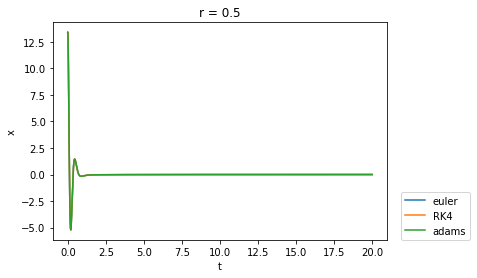

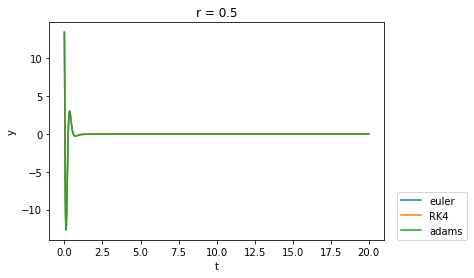

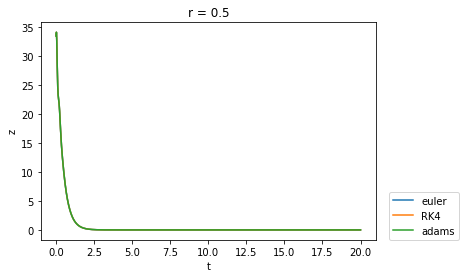

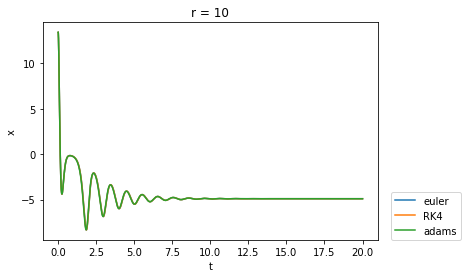

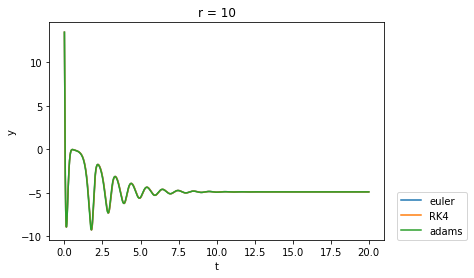

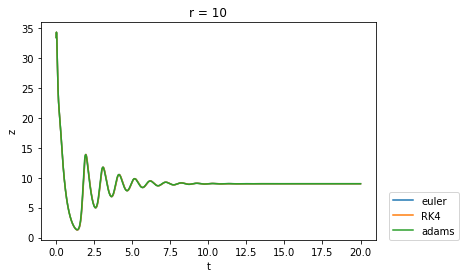

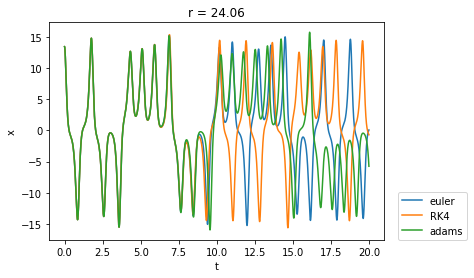

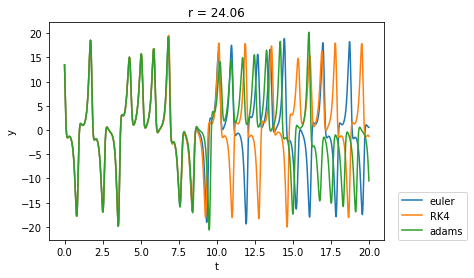

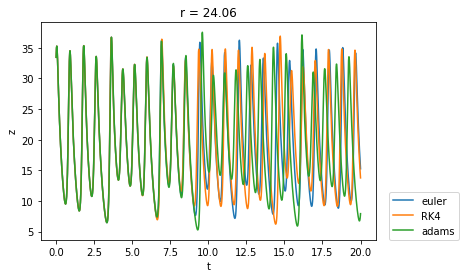

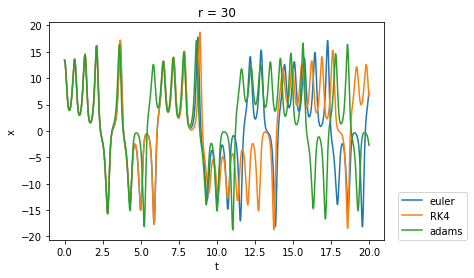

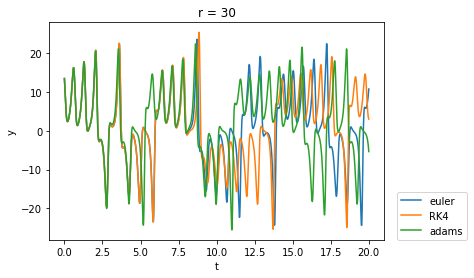

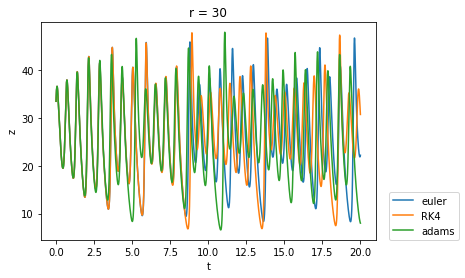

In [15]:
draw_2D(results)